In [1]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

### 비선형 변형

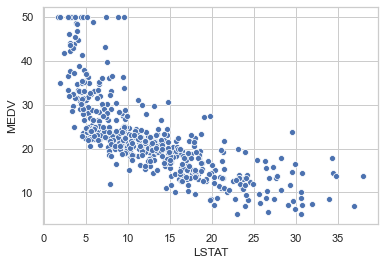

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX, dfy], axis=1)

sns.scatterplot(x="LSTAT", y="MEDV", data=df_boston)
plt.show()

In [3]:
model1 = sm.OLS.from_formula("MEDV ~ LSTAT", data=df_boston)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           5.08e-88
Time:                        13:29:03   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

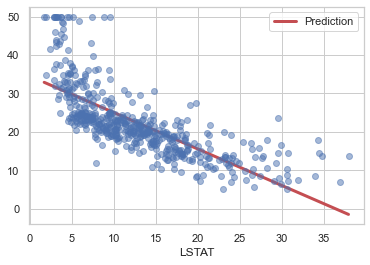

In [4]:
y_hat1 = result1.predict(df_boston)
df1 = pd.concat([y_hat1, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df1.columns = ["Prediction", "LSTAT"]
df1.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

In [5]:
model2 = sm.OLS.from_formula("MEDV ~ LSTAT + I(LSTAT**2)", data=df_boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          1.56e-112
Time:                        13:29:14   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

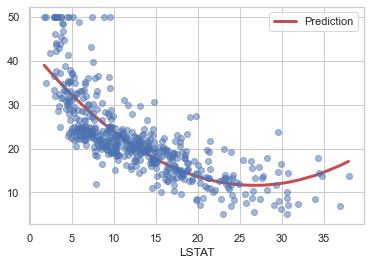

In [6]:
y_hat2 = result2.predict(df_boston)
df2 = pd.concat([y_hat2, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df2.columns = ["Prediction", "LSTAT"]
df2.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

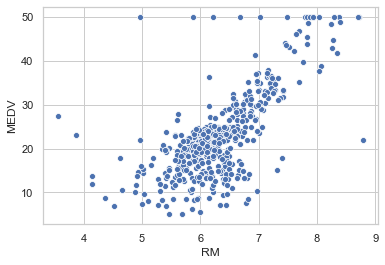

In [7]:
sns.scatterplot(x="RM", y="MEDV", data=df_boston)
plt.show()

In [8]:
model3 = sm.OLS.from_formula("MEDV ~ RM", data=df_boston)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.49e-74
Time:                        13:29:43   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

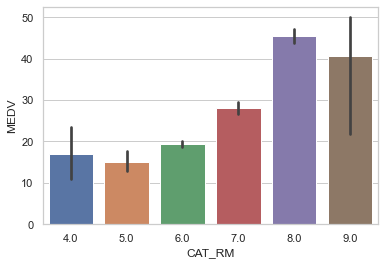

In [9]:
# 비선형성이 심하게 보일 경우, 카테고리 변수로 변환
rooms = np.arange(3, 10)
labels = [str(r) for r in rooms[:-1]]
df_boston["CAT_RM"] = np.round(df_boston.RM)

sns.barplot(x="CAT_RM", y="MEDV", data=df_boston)
plt.show()

In [10]:
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))", data=df_boston)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     115.8
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.57e-81
Time:                        13:33:34   Log-Likelihood:                -1645.6
No. Observations:                 506   AIC:                             3303.
Df Residuals:                     500   BIC:                             3329.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

### 시간 독립변수의 변형

In [11]:
data = sm.datasets.get_rdataset("elecdaily", package="fpp2")

df_elec = data.data.drop(columns=["WorkDay", "Temperature"])
df_elec["Date"] = pd.date_range("2014-1-1", "2014-12-31")
df_elec.tail()

,Demand,Date
360,173.727990,2014-12-27
361,188.512817,2014-12-28
362,191.273009,2014-12-29
363,186.240144,2014-12-30
364,186.370181,2014-12-31


In [12]:
import datetime as dt

# 시간단위는 반드시 스캐일링
df_elec["Ordinal"] = df_elec.Date.map(dt.datetime.toordinal)
df_elec["Timestamp"] = df_elec.Date.map(dt.datetime.timestamp)
df_elec.tail()

,Demand,Date,Ordinal,Timestamp
360,173.727990,2014-12-27,735594,1.419606e+09
361,188.512817,2014-12-28,735595,1.419692e+09
362,191.273009,2014-12-29,735596,1.419779e+09
363,186.240144,2014-12-30,735597,1.419865e+09
364,186.370181,2014-12-31,735598,1.419952e+09


In [13]:
model5 = sm.OLS.from_formula("Demand ~ scale(Ordinal)", data=df_elec)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.58
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           0.000739
Time:                        13:33:55   Log-Likelihood:                -1709.7
No. Observations:                 365   AIC:                             3423.
Df Residuals:                     363   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        221.2775      1.374    160.

- 하지만 시간 독립변수는 이 외에더 다양한 특징들을 숨기고 있다. 예들 들어 연도, 월, 일, 요일 데이터를 별도의 독립변수로 분리하거나 한 달 내에서 몇번째 날짜인지 월의 시작 또는 끝인지를 나타내는 값은 모두 특징값이 될 수 있다. 판다스에서는 `dt` 특수 연산자를 사용하여 이러한 값을 구할 수 있다.

In [14]:
df_elec["Year"] = df_elec.Date.dt.year
df_elec["Month"] = df_elec.Date.dt.month
df_elec["DayOfYear"] = df_elec.Date.dt.dayofyear
df_elec["DayOfMonth"] = df_elec.Date.dt.daysinmonth
df_elec["DayOfWeek"] = df_elec.Date.dt.dayofweek
df_elec["WeekOfYear"] = df_elec.Date.dt.weekofyear
df_elec["Weekday"] = df_elec.Date.dt.weekday
df_elec["IsMonthStart"] = df_elec.Date.dt.is_month_start
df_elec["IsMonthEnd"] = df_elec.Date.dt.is_month_end
df_elec.tail()

,Demand,Date,Ordinal,Timestamp,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,WeekOfYear,Weekday,IsMonthStart,IsMonthEnd
360,173.727990,2014-12-27,735594,1.419606e+09,2014,12,361,31,5,52,5,False,False
361,188.512817,2014-12-28,735595,1.419692e+09,2014,12,362,31,6,52,6,False,False
362,191.273009,2014-12-29,735596,1.419779e+09,2014,12,363,31,0,1,0,False,False
363,186.240144,2014-12-30,735597,1.419865e+09,2014,12,364,31,1,1,1,False,False
364,186.370181,2014-12-31,735598,1.419952e+09,2014,12,365,31,2,1,2,False,True


In [15]:
feature_names = df_elec.columns.tolist()
feature_names.remove("Demand")
feature_names.remove("Date")

formula = """
Demand ~ scale(Ordinal) + C(Month) + DayOfYear + 
         C(DayOfMonth) + C(DayOfWeek) + C(Weekday) + C(IsMonthStart) + C(IsMonthEnd)
"""
model6 = sm.OLS.from_formula(formula, data=df_elec)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     19.98
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           4.74e-46
Time:                        13:35:55   Log-Likelihood:                -1574.8
No. Observations:                 365   AIC:                             3192.
Df Residuals:                     344   BIC:                             3273.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### 주기성을 가지는 독립변수

In [16]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

feature_names = ["Aspect", "Hillshade_9am"]
df_covtype = pd.DataFrame(covtype.data[:, [1, 6]], columns=feature_names)
df_covtype = df_covtype.sample(10000, random_state=0)  # 편의상 10,000개 표본 추출
df_covtype.tail()

,Aspect,Hillshade_9am
77297,90.0,235.0
103214,38.0,220.0
459385,79.0,241.0
159359,58.0,225.0
565783,91.0,240.0


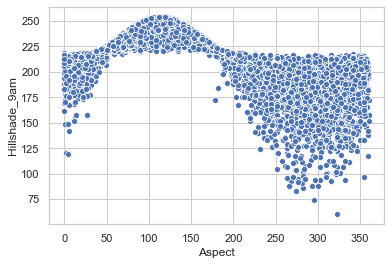

In [17]:
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.show()

In [18]:
model7 = sm.OLS.from_formula(
    "Hillshade_9am ~ Aspect + I(Aspect**2) + I(Aspect**3)", 
    data=df_covtype
)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7974.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:38:09   Log-Likelihood:                -40905.
No. Observations:               10000   AIC:                         8.182e+04
Df Residuals:                    9996   BIC:                         8.185e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        187.0395      0.485    385.

In [19]:
df_test = pd.DataFrame([[0], [360]], columns=["Aspect"])
df_result7 = result7.predict(df_test)
df_result7

0    187.039453
1    193.002560
dtype: float64

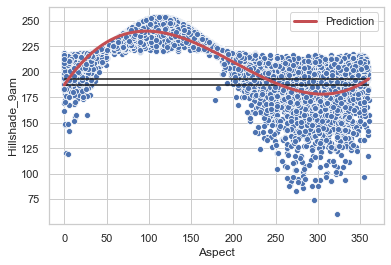

In [20]:
y_hat7 = result7.predict(df_covtype)
df7 = pd.concat([y_hat7, df_covtype.Aspect], axis=1).sort_values("Aspect")
df7.columns = ["Prediction", "Aspect"]
df7.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result7.values[0], 0, 360)
plt.hlines(df_result7.values[1], 0, 360)
plt.show()

$$ x \;\; \rightarrow
\begin{cases}
x_1 = \cos\left(\frac{2\pi}{360}x\right) \\
x_2 = \sin\left(\frac{2\pi}{360}x\right) 
\end{cases} $$

In [21]:
f = 2.0 * np.pi / 360

model8 = sm.OLS.from_formula("""
Hillshade_9am ~ 
np.cos(f * Aspect) +
np.sin(f * Aspect)
""", data=df_covtype
)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.334e+04
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:38:27   Log-Likelihood:                -40515.
No. Observations:               10000   AIC:                         8.104e+04
Df Residuals:                    9997   BIC:                         8.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            208.8444      0

In [22]:
df_result8 = result8.predict(df_test)
df_result8

0    196.069868
1    196.069868
dtype: float64

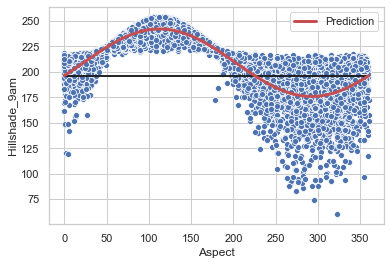

In [23]:
y_hat8 = result8.predict(df_covtype)
df8 = pd.concat([y_hat8, df_covtype.Aspect], axis=1).sort_values("Aspect")
df8.columns = ["Prediction", "Aspect"]
df8.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result8.values[0], 0, 360)
plt.hlines(df_result8.values[1], 0, 360)
plt.show()

### 종속변수 변형

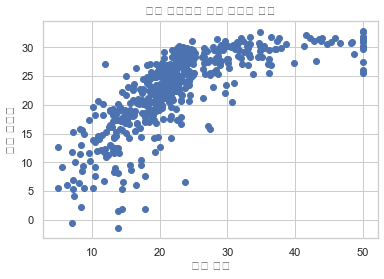

In [25]:
plt.scatter(boston.target, y_hat1)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()

In [26]:
model11 = sm.OLS.from_formula("np.sqrt(MEDV) ~ LSTAT", data=df_boston)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:          np.sqrt(MEDV)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     789.7
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          3.09e-105
Time:                        13:39:35   Log-Likelihood:                -445.65
No. Observations:                 506   AIC:                             895.3
Df Residuals:                     504   BIC:                             903.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9499      0.053    112.374      0.0

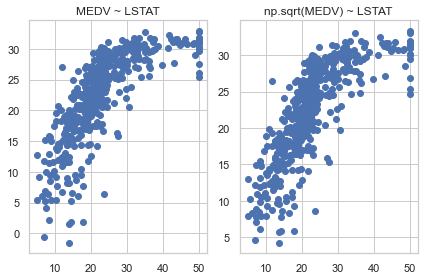

In [27]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, (result11.predict(df_boston))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [28]:
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT", data=df_boston)
result12 = model12.fit()
print(result12.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.1
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          2.23e-116
Time:                        13:39:44   Log-Likelihood:               -0.57634
No. Observations:                 506   AIC:                             5.153
Df Residuals:                     504   BIC:                             13.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6176      0.022    164.654      0.0

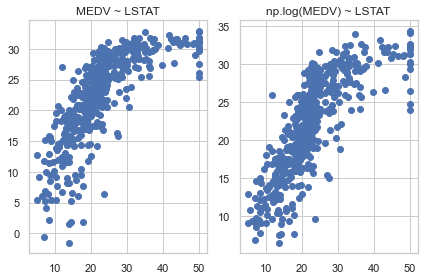

In [29]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result12.predict(df_boston)))
plt.title("np.log(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()


In [30]:
model13 = sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=df_boston)
result13 = model13.fit()
print(result13.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          7.32e-126
Time:                        13:39:52   Log-Likelihood:                 21.325
No. Observations:                 506   AIC:                            -38.65
Df Residuals:                     504   BIC:                            -30.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3618      0.042    103.603

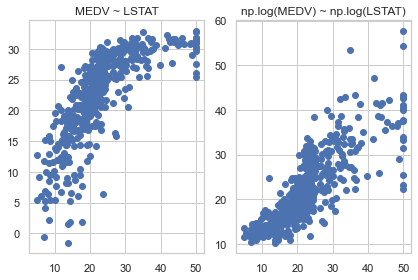

In [31]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result13.predict(df_boston)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()